# How to break the Uzawa method

The objective of this study is to determine ways to alter the Uzawa method in a DMPC situation. We consider several users accessing a limited amount of ressources and, with the help of a coordinator, a DMPC optimaly distributes the ressouce among the users.

The idea here is to focus on a user whose objective would be to destroy the system.

For the sake of the simplicity, our study will be on a static model but please note that all those results can easily be extended to the DMPC.

-- Sylvain Chatel, July 2016 --

In [1]:
from __future__ import division, print_function
import StaticOptimization as SO
import DMPC_Draft as DO
from cvxopt import matrix, solvers
import numpy as np
from tabulate import tabulate
import matplotlib.pyplot as plt
from tempfile import TemporaryFile
%matplotlib inline

/Users/sylvainchatel/anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


## Influence of cheating throught comfort on Uzawa

In this section, we will try to explicit the consequences of a cheat throught comfort on the Uzawa convergence. To this end, we consider a problem of three users.

In [2]:
# number of users
m = 3
# vector of users
i = np.arange(m)
# max energy in kW
Umax = 2
# max admissible energy
u_m = np.array([1, 1, 1], dtype=float)
# Thermal parameters
    ## Thermal resistance
Rth =np.array([10, 10, 10])
    ## Exterior temperature
Text = 10
    ## Ideal temperature in degrees
T_id = np.array([21, 21, 21], dtype=float)
# comfort factor
alpha = np.asarray([10, 10, 10], dtype=float)

pb = dict(Rth=Rth, Text=Text, T_id=T_id, Umax=Umax, u_m=u_m, alpha=alpha, m=m)

break at 216.


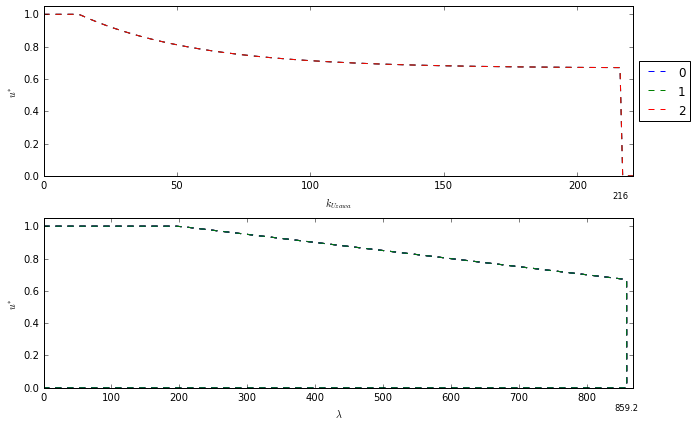

In [3]:
SO.pwrdist(pb, 15, 1.0e-2, k_max=1000)
plt.show()

In [4]:
pb['alpha'] = np.asarray([1.0e4, 1.0e4, 1.0e4], dtype=float)

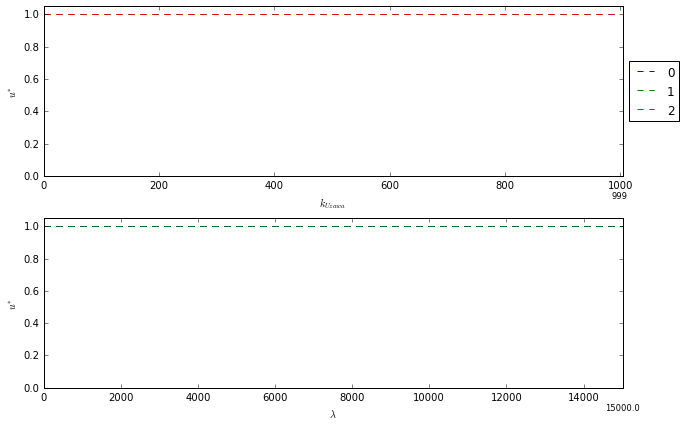

In [5]:
SO.pwrdist(pb, 15, 1.0e-2, k_max=1000)
plt.show()

On the figure above, we can see that for huge value of $\alpha$, the Uzawa method seems to not converge (indeed we reach the maximum number of iteration k_max). Hence we can say that the comfort factor has an impact on the convergence.

Howerver, our study shows that this effect is only seen when all users have a huge value of comfort. If only one user has a huge value e.g. [10, 10, $10^{25}$], the Uzawa method works.

## Destroy Uzawa with inputs

In this section, we aim to see if a predetermine sequence of inputs can force the Uzawa method used in the DMPC to fail. Please note that in this section, we are using the dynamic model in order to take into account the temporal aspect of the destroying sequence but we are using a centralized method in order to get simpler results. Still, those results could be extended to the DMPC.

We consider two users. The first user is rational, the second one is nihilist.

In [6]:
# number of users
m = 2
# vector of users
i = np.arange(m)
# Time step
dt = 0.1  # h
# Simulation Horizon
N_sim = int(24/dt)
# Prediction Horizon
N = int(5/dt)
# max energy in kW
Umax = 2
# max admissible energy
u_m = np.array([2, 2], dtype=float)
# Detroying user
user_nhl = 1
# Destroying power sequence
u1_hor = np.ones(N_sim+N)*u_m[1]

for j in range((N_sim+N)//2):
    u1_hor[2*j] = 0

u1_sim = u1_hor[0:N_sim]

# thermal parameters
        ## Exterior Temperature on the whole horizon
Text_sim = np.ones(m*(N_sim + N))*0
        ## Exterior Temperature on the prediction horizon initially
Text = Text_sim[0:m*N]
        ## Temperature when present
Tpres = 22
        ## Temperature when absent
Tabs = 18
        ## Initial temperature in all users
T_init = np.array([10, 10], dtype=float)
        ## Thermal Resistance
Rth = np.array([50, 50], dtype=float)
        ## Thermal Capacity
Cth = np.array([0.056, 0.056], dtype=float)
        ## Reference temperature through the whole horizon
T_mod = np.hstack(
    (DO.temp_id(N_sim + N, dt, Tabs, Tpres), 
     DO.temp_id(N_sim + N, dt, Tabs, Tpres)))  ## ATTENTION : defined user after user
        ## Reference temperature through the simulation horizon
T_id_pred = np.hstack(
    (DO.temp_id(N_sim, dt, Tabs, Tpres), 
     DO.temp_id(N_sim, dt, Tabs, Tpres)))  ## ATTENTION : defined user after user
# comfort factor
alpha = np.array([10, 10], dtype=float)

# Definition of the dictionary
pb = dict(m=m, dt=dt, Umax=Umax, u_m=u_m, Text=Text, Text_sim=Text_sim,
          T_mod=T_mod, T_init=T_init, Rth=Rth, Cth=Cth,T_id_pred=T_id_pred, 
          alpha=alpha, N=N, N_sim=N_sim, u1_hor=u1_hor, u1_sim=u1_sim, user_nhl=user_nhl)

In [7]:
T_opt, U_opt, cost_opt, J_u_opt = DO.optim_central_CL(pb)
T_nhl, U_nhl, cost_nhl, J_u_nhl = DO.get_Opt_Seq(pb)

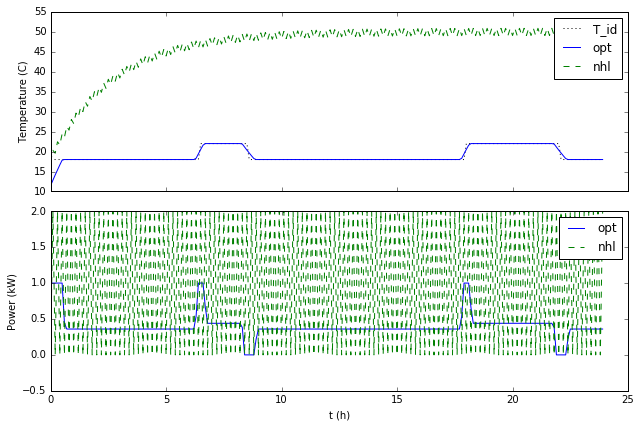

(<matplotlib.figure.Figure at 0x10cd97490>,
 (<matplotlib.axes._subplots.AxesSubplot at 0x10f820210>,
  <matplotlib.axes._subplots.AxesSubplot at 0x10cdbb450>))

In [8]:
DO.plot_T(pb, pb['user_nhl'], T_opt, U_opt, 'opt', T_nhl, U_nhl, 'nhl')

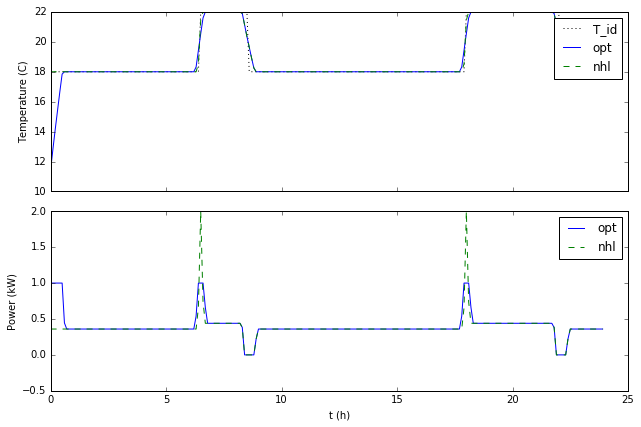

(<matplotlib.figure.Figure at 0x10a3c3650>,
 (<matplotlib.axes._subplots.AxesSubplot at 0x10a3d9e90>,
  <matplotlib.axes._subplots.AxesSubplot at 0x11013a9d0>))

In [9]:
DO.plot_T(pb, pb['user_nhl']-1, T_opt, U_opt, 'opt', T_nhl, U_nhl, 'nhl')

On the figure above, we notice that for a particular sequence, a nihilist user can alter the behaviour of the DMPC. Indeed, by having a poxer sequence of [0, Umax, 0, Umax ..], the user 1 disturbs the results of the distribution for user 0.

# Conclusion

Throughout this study, we were able to recreate user with malicious will against the DMPC. With two different startegies, we pointed out that a user whose objective would be to alter the distribution could do so by forcing a high comfort factor for every user or use a predetermine power sequence instead of the optimization result. However, those situations could be prevented by using one of the strategies studied in the cheating detection study.